## Preprocess for Movie data
This part mainly focuses on preprocess such as data transformation, data cleaning and getting a basic understanding of the feature of each variable.

In [1]:
# Make the chunk output all results not only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Import libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
from nltk.util import ngrams
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import ast
from datetime import datetime
import time

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [3]:
# Load data
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

# Look at the data
train.head(10)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
5,6,NaN,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,/6IDqA1D2NBIVhzEEaMMRL28iBrq.jpg,NaN,NaN,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Pinocchio and the Emperor of the Night,NaN,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638
6,7,NaN,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.thepossessionmovie.com/,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,/4QjzFuaZmB4btGnLwAgdp23BzIU.jpg,"[{'name': 'Ghost House Pictures', 'id': 768}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear The Demon That Doesn't Fear God,The Possession,NaN,"[{'c

In [4]:
# Look at the shape of train data
train.shape

# Look at the shape of test data
test.shape

(3000, 23)

(4398, 22)

The train dataset only has 3000 observations, which is smaller than the test dataset. I think this will make training an accurate model much harder.

In [5]:
# Print out the columns name
train.columns.values

array(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew', 'revenue'], dtype=object)

I noticed that some columns contain one or more json structure. They are `belongs_to_collection`, `genres`, `production_companies`, `production_countries`, `spoken_languages`, `Keywords`, `cast` and `crew`.

To analyze the data, the first step is to convert some json columns into dictionaries, so we can extract information from those columns later.

In [6]:
# Write a function to do this for both train and test dataset
def convert_json(df):
    columns_need_convert=['belongs_to_collection', 'genres', 'production_companies',
                          'production_countries', 'spoken_languages', 'Keywords', 
                          'cast', 'crew']
    for name in columns_need_convert:
        df[name]=df[name].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    
    return(df)

train=convert_json(train)
test=convert_json(test)

## Let's look at the variables one by one

### *id*

This column is used to represent different movies and does not useful for explaining revenue, so we don't need to analyze it in depth. 

### *belongs_to_collection*

In [7]:
# Look at this column
for collection in train.belongs_to_collection[:5]:
    print(collection)

[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
[{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
{}
{}
{}


In [8]:
# Create a new column to store the name of the collection
train['collection']=train["belongs_to_collection"].apply(lambda x: x[0]['name'] if x!={} else np.nan)
test['collection']=test["belongs_to_collection"].apply(lambda x: x[0]['name'] if x!={} else np.nan)

# Create a new column to represent whether a movie has a collection
train['has_collection']=train["belongs_to_collection"].apply(lambda x: len(x) if x!={} else 0)
test['has_collection']=test["belongs_to_collection"].apply(lambda x: len(x) if x!={} else 0)

In [9]:
# Look at the new columns
train.collection.head()
train.has_collection.head()

0    Hot Tub Time Machine Collection
1    The Princess Diaries Collection
2                                NaN
3                                NaN
4                                NaN
Name: collection, dtype: object

0    1
1    1
2    0
3    0
4    0
Name: has_collection, dtype: int64

In [10]:
# Count NAs
sum(train.collection.isnull())
sum(test.collection.isnull())

2396

3521

There are 2396 movies do not have a collection in the train dataset, but they are not outliers. It is normal that some movies do not have a collection. After transformation, we can drop `belongs_to_collection` to save space.

In [11]:
train = train.drop(['belongs_to_collection'], axis=1)
test = test.drop(['belongs_to_collection'], axis=1)

### *Budget*

In [12]:
# Count NAs
sum(train.budget.isnull())
sum(test.budget.isnull())

# Count 0
len(train[train['budget']==0])
len(test[test['budget']==0])

0

0

812

1211

There is no missing value, but there are many observations who have budget = 0, which is not likely to be valid. However, 0 budget observation is a pretty big fraction, so we cannot just drop them. I will deal with these values later.

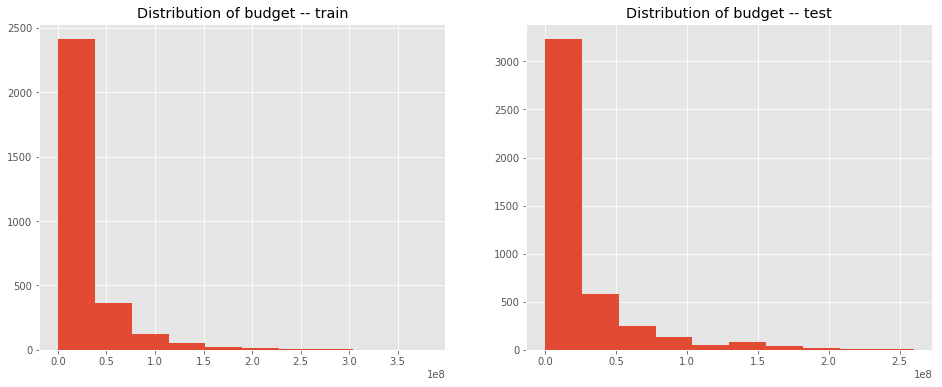

In [13]:
# Plot histogram
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget']);
plt.title('Distribution of budget -- train');

plt.subplot(1, 2, 2)
plt.hist(test['budget']);
plt.title('Distribution of budget -- test');

The budget is highly skewed, so we need to convert budget into log form to correct this problem.

In [14]:
# Convert budget into log(budget)
train['log_budget']=np.log1p(train['budget'])
test['log_budget']=np.log1p(test['budget'])

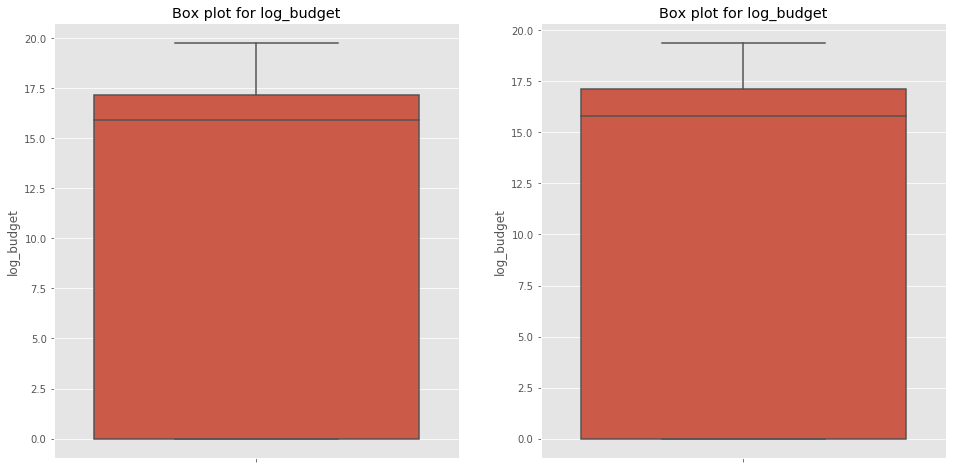

In [15]:
# Box plot to see outliers
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(y='log_budget', data=train);
plt.title('Box plot for log_budget');

plt.subplot(1, 2, 2)
sns.boxplot(y='log_budget', data=test);
plt.title('Box plot for log_budget');

No obvious outliers and the data structure for train and test data is similar, which is good.

### *genres*

In [16]:
# Look at this column
for genres in train.genres[:5]:
    print(genres)

[{'id': 35, 'name': 'Comedy'}]
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
[{'id': 18, 'name': 'Drama'}]
[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
[{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


We can see that some observations have more than one genres.

In [17]:
# Create a new column to store all genres
train['genres_name']=train["genres"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['genres_name']=test["genres"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Create a new column to represent the total number of genre a movie has
train['n_genres']=train["genres"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test['n_genres']=test["genres"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [18]:
# Look at the new column
train['genres_name'].head()
train['n_genres'].head()

0                            [Comedy]
1    [Comedy, Drama, Family, Romance]
2                             [Drama]
3                   [Thriller, Drama]
4                  [Action, Thriller]
Name: genres_name, dtype: object

0    1
1    4
2    1
3    2
4    2
Name: n_genres, dtype: int64

In [19]:
print('Number of genres')
types=pd.DataFrame(train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts())
types.columns=["# of Movie"]
types

Number of genres


,# of Movie
2,972
3,900
1,593
4,393
5,111
6,21
0,7
7,3


#### There are outliers! 
For example, there are 7 movies having 0 genres, which is impossible; also there are 3 movies having 7 genres, which is too many. Usually, 1-5 is a normal range. I will make decision on how to process these outliers later.

In [20]:
# Make a genres list
genres_list = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
# Count for each genres
genres=pd.DataFrame(Counter([i for j in genres_list for i in j]).most_common())
genres.columns = ['genres', 'number']
genres

,genres,number
0,Drama,1531
1,Comedy,1028
2,Thriller,789
3,Action,741
4,Romance,571
5,Crime,469
6,Adventure,439
7,Horror,301
8,Science Fiction,290
9,Family,260


There are almost 20 genres, so I choose to make new columns, which are used to mark the movie with top 11 popular genres (number of movies >200).

In [21]:
g_list=[g[0] for g in Counter([i for j in genres_list for i in j]).most_common(11)]

In [22]:
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in g_list:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
    
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in g_list:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

In [23]:
# Drop this column
train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)

### *homepage*

Since most of the value in homepage column is unique, I want to convert homepage into a binary variable, such that 
    * 0--no homepage
    * 1--has homepage

In [24]:
# Count NAs
sum(train['homepage'].isnull())
sum(test['homepage'].isnull())

2054

2978

In [25]:
# Create a new binary column
train['has_homepage']=0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1

test['has_homepage']=0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

In [26]:
# Drop this column
train = train.drop(['homepage'], axis=1)
test = test.drop(['homepage'], axis=1)

### *imdb_id*

Same as `id` variable, this column is not very useful for predicting revenue, so I will not analyze it.

In [27]:
# Drop this column
train = train.drop(['imdb_id'], axis=1)
test = test.drop(['imdb_id'], axis=1)

### *original_language*

In [28]:
# Look at this column
for ol in train['original_language'][:5]:
    print(ol)

en
en
en
hi
ko


In [29]:
# Count NAs
sum(train['original_language'].isnull())
sum(test['original_language'].isnull())

0

0

For now, there is no need to process `original_language`. We can explore it later in the exploratory data analysis part. 

### *original_title*

For variable which contains text, I will not process now. However, if the model is not very good, I will come back and think about a way how to deal with it. For now, let's just look at the word cloud for train dataset to get a basic understanding.

<Figure size 1152x576 with 0 Axes>

Text(0.5,1,'Top words in original title -- train')

(-0.5, 1199.5, 999.5, -0.5)

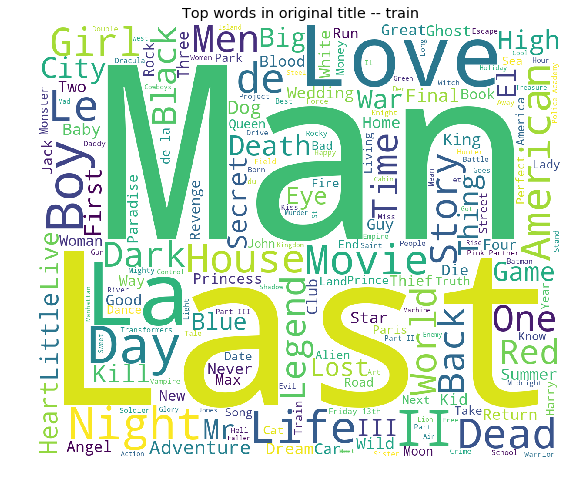

In [30]:
# Word cloud for train
plt.figure(figsize=(16, 8))
text = ' '.join(train['original_title'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in original title -- train')
plt.axis("off")
plt.show()

### *overview*

<Figure size 1152x576 with 0 Axes>

Text(0.5,1,'Top words in overview -- train')

(-0.5, 1199.5, 999.5, -0.5)

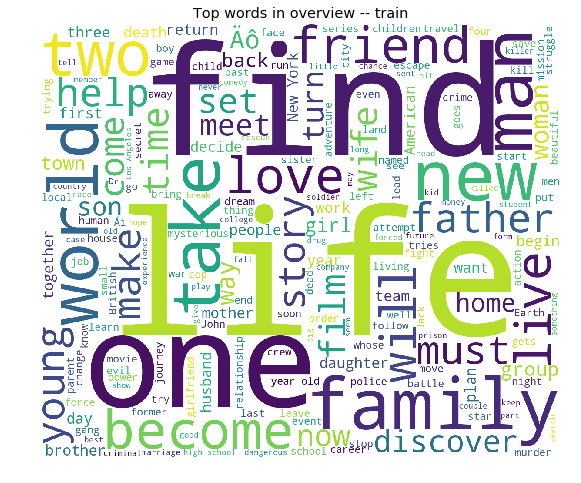

In [31]:
# Word cloud for train
plt.figure(figsize=(16, 8))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview -- train')
plt.axis("off")
plt.show()

### *popularity*

In [32]:
# Summary Statistics
train['popularity'].describe()
test['popularity'].describe()

count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: float64

count    4398.000000
mean        8.550230
std        12.209014
min         0.000001
25%         3.895186
50%         7.482241
75%        10.938524
max       547.488298
Name: popularity, dtype: float64

In [33]:
# Count NAs
sum(train['popularity'].isnull())
sum(test['popularity'].isnull())

0

0

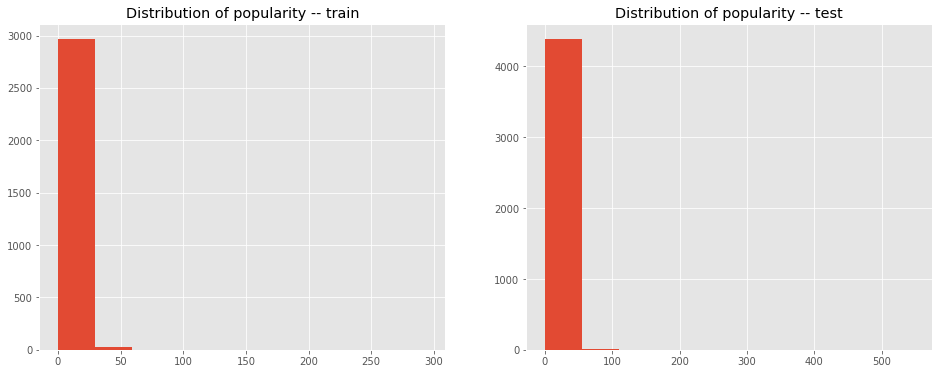

In [34]:
# Plot histogram
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['popularity']);
plt.title('Distribution of popularity -- train');

plt.subplot(1, 2, 2)
plt.hist(test['popularity']);
plt.title('Distribution of popularity -- test');

In [35]:
# Convert popularity into log(popularity) to correct skewness
train['log_popularity']=np.log1p(train['popularity'])
test['log_popularity']=np.log1p(test['popularity'])

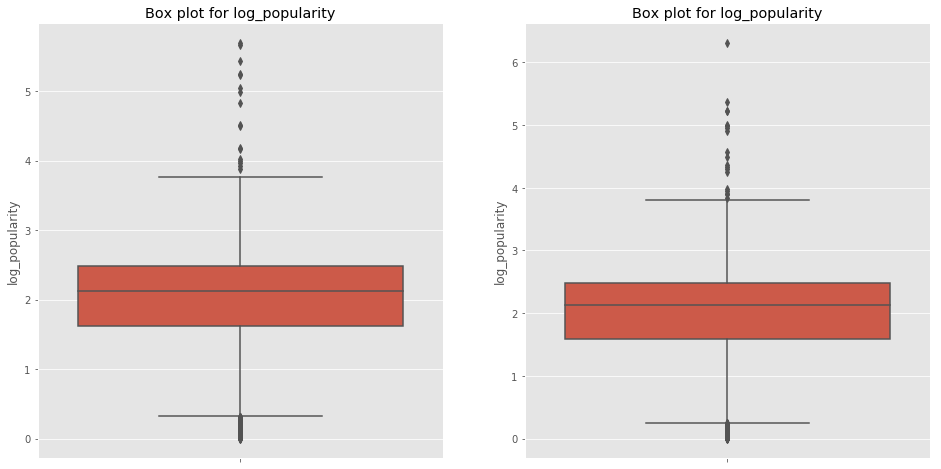

In [36]:
# Box plot to see outliers
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(y='log_popularity', data=train);
plt.title('Box plot for log_popularity');

plt.subplot(1, 2, 2)
sns.boxplot(y='log_popularity', data=test);
plt.title('Box plot for log_popularity');

For now we will keep these outliers and drop them if they will influence the accuracy of model in later step. 

### *poster_path*

In [37]:
# Count NAs
sum(train['poster_path'].isnull())
sum(test['poster_path'].isnull())

1

1

`poster_path` is not very useful for predicting revenue. Since there is only one missing value, creating a new column to represent whether a movie has poster path or not is meaningless. Therefore, I will drop this column.

In [38]:
# Drop this column
train = train.drop(['poster_path'], axis=1)
test = test.drop(['poster_path'], axis=1)

### *production_companies*

In [39]:
# Look at this column
for pc in train.production_companies[:5]:
    print(pc)

[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
[{'name': 'Walt Disney Pictures', 'id': 2}]
[{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
{}
{}


In [40]:
# Create a new column to store all company
train['company']=train["production_companies"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['company']=test["production_companies"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Count the number of company
train['n_company']=train["production_companies"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test['n_company']=test["production_companies"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [41]:
# Look at the new column
train['company'].head()
train['n_company'].head()

0    [Paramount Pictures, United Artists, Metro-Gol...
1                               [Walt Disney Pictures]
2    [Bold Films, Blumhouse Productions, Right of W...
3                                                  NaN
4                                                  NaN
Name: company, dtype: object

0    3
1    1
2    3
3    0
4    0
Name: n_company, dtype: int64

In [42]:
# Summary of the number of company
print("The number of Company:")
print(train['n_company'].value_counts())

The number of Company:
1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: n_company, dtype: int64


#### There are outliers !
0 company and more than 10 companies are not reasonable.

I am not sure how to deal with this column now, so I decide to create individual column for top 20 companies.

In [43]:
# For every single company
# Cannot directly use train['company'], because for that one we set 'np.nan' rather than "[]"
company_list = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Count for each company
company_list_1=pd.DataFrame(Counter([i for j in company_list for i in j]).most_common(20))
company_list_1.columns = ['company', 'number']
company_list_1

,company,number
0,Warner Bros.,202
1,Universal Pictures,188
2,Paramount Pictures,161
3,Twentieth Century Fox Film Corporation,138
4,Columbia Pictures,91
5,Metro-Goldwyn-Mayer (MGM),84
6,New Line Cinema,75
7,Touchstone Pictures,63
8,Walt Disney Pictures,62
9,Columbia Pictures Corporation,61


In [44]:
# Create individual column
c_list=[m[0] for m in Counter([i for j in company_list for i in j]).most_common(20)]

train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in c_list:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in c_list:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

In [45]:
# Drop this column
train = train.drop(['production_companies'], axis=1)
test = test.drop(['production_companies'], axis=1)

### *production_countries*

In [46]:
# Look at this column
for pc in train.production_countries[:5]:
    print(pc)

[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'IN', 'name': 'India'}]
[{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [47]:
# Create a new column to store all countries
train['country']=train["production_countries"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['country']=test["production_countries"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Count the countries
train['n_country']=train["production_countries"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test['n_country']=test["production_countries"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [48]:
# Look at the new columns
train['country'].head()
train['n_country'].head()

0    [United States of America]
1    [United States of America]
2    [United States of America]
3                       [India]
4                 [South Korea]
Name: country, dtype: object

0    1
1    1
2    1
3    1
4    1
Name: n_country, dtype: int64

In [49]:
# Summary of the number of country
print("The number of Country:")
print(train['n_country'].value_counts())

The number of Country:
1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: n_country, dtype: int64


#### There are outliers

The number of production country cannot be 0, and there are some movies having more than 4 production countries, which is not reasonable.

Next, I will create individual column for top 15 production country.

In [50]:
# For every single country
country_list = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Count for each country
country_list_1=pd.DataFrame(Counter([i for j in country_list for i in j]).most_common(15))
country_list_1.columns = ['country', 'number']
country_list_1

,country,number
0,United States of America,2282
1,United Kingdom,380
2,France,222
3,Germany,167
4,Canada,120
5,India,81
6,Italy,64
7,Japan,61
8,Australia,61
9,Russia,58


In [51]:
# Create individual column
c_list_2=[m[0] for m in Counter([i for j in country_list for i in j]).most_common(15)]

train['all_production_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in c_list_2:
    train['production_country_' + g] = train['all_production_countries'].apply(lambda x: 1 if g in x else 0)
    
test['all_production_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in c_list_2:
    test['production_country_' + g] = test['all_production_countries'].apply(lambda x: 1 if g in x else 0)

In [52]:
# Drop this column
train = train.drop(['production_countries'], axis=1)
test = test.drop(['production_countries'], axis=1)

### *release_date*

In [53]:
# Look at the data
for rd in train['release_date'][:5]:
    print(rd)

2/20/15
8/6/04
10/10/14
3/9/12
2/5/09


In [54]:
# Check the NAs
sum(train['release_date'].isna())
sum(test['release_date'].isna())

# Fill NAs
test['release_date']=test['release_date'].fillna("1/1/70")

0

1

I want to convert release_date column into datetime type, so then I can extract attributes I want to use very easy. To do that, I found the format of date in this column is not a standard format to convert. Therefore, the first step is to fix the format.

In [55]:
# Function to fix the format
def fix_format(x):
    month, day, year = x.split('/')
    if len(month)==1:
        month="0"+month
        
    if len(day)==1:
        day="0"+day
        
    if int(year)<=19:
        year="20"+year
    else:
        year="19"+year
        
    return(month+"/"+day+"/"+year)
                               
# Convert the column
train['release_time']=train["release_date"].apply(lambda x: datetime.strptime(fix_format(x), "%m/%d/%Y"))
test['release_time']=test["release_date"].apply(lambda x: datetime.strptime(fix_format(x), "%m/%d/%Y"))

In [56]:
# Extract year, month, DOW
train['year']=train['release_time'].apply(lambda x: x.year)
train['month']=train['release_time'].apply(lambda x: x.month)
train['DOW']=train['release_time'].apply(lambda x: x.weekday())    

test['year']=test['release_time'].apply(lambda x: x.year)
test['month']=test['release_time'].apply(lambda x: x.month)
test['DOW']=test['release_time'].apply(lambda x: x.weekday()) 

In [57]:
# Write a function to create season
def season(row):
    if row['month']==3 or row['month']==4 or row['month']==5:
        return(1)
    elif row['month']==6 or row['month']==7 or row['month']==8:
        return(2)
    elif row['month']==9 or row['month']==10 or row['month']==11:
        return(3)
    elif row['month']==12 or row['month']==1 or row['month']==2:
        return(4)
    
# Write a function to create weekend
def weekend(row):
    if row['DOW']==0 or row['DOW']==6:
        return(1)
    else:
        return(0)

In [58]:
# Create a new column 'season'
train['season']=train.apply(lambda row:season(row), axis=1)
test['season']=test.apply(lambda row:season(row), axis=1)
train['season'].head()

# Create a new column 'Weekend'
train['Weekend']=train.apply(lambda row: weekend(row), axis=1)
test['Weekend']=test.apply(lambda row: weekend(row), axis=1)
train['Weekend'].head()

0    4
1    2
2    3
3    1
4    4
Name: season, dtype: int64

0    0
1    0
2    0
3    0
4    0
Name: Weekend, dtype: int64

In [59]:
# Drop this column
train = train.drop(['release_date'], axis=1)
test = test.drop(['release_date'], axis=1)

### *runtime*

In [60]:
# Summary Statistics
train['runtime'].describe()
test['runtime'].describe()

count    2998.000000
mean      107.856571
std        22.086434
min         0.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64

count    4394.000000
mean      107.622212
std        21.058290
min         0.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       320.000000
Name: runtime, dtype: float64

In [61]:
# Count 0
len(train[train['runtime']==0])
len(test[test['runtime']==0])

# Count NAs
sum(train.runtime.isnull())
sum(test.runtime.isnull())

# Fill NAs
train['runtime']=train.runtime.fillna(0)
test['runtime']=test.runtime.fillna(0)

12

9

2

4

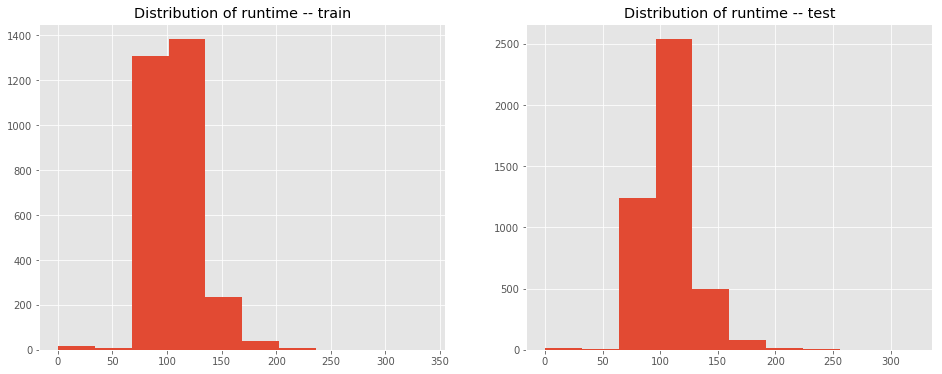

In [62]:
# Plot histogram
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['runtime']);
plt.title('Distribution of runtime -- train');

plt.subplot(1, 2, 2)
plt.hist(test['runtime']);
plt.title('Distribution of runtime -- test');

### *spoken_languages*

In [63]:
# Look at this column
for sl in train.spoken_languages[:5]:
    print(sl)

[{'iso_639_1': 'en', 'name': 'English'}]
[{'iso_639_1': 'en', 'name': 'English'}]
[{'iso_639_1': 'en', 'name': 'English'}]
[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [64]:
# Create a new column to store all languages
train['language']=train["spoken_languages"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['language']=test["spoken_languages"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Count the languages
train['n_lan']=train["spoken_languages"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test['n_lan']=test["spoken_languages"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [65]:
# Look at these new columns
train["language"].head()
train["n_lan"].head()

0            [English]
1            [English]
2            [English]
3    [English, हिन्दी]
4            [한국어/조선말]
Name: language, dtype: object

0    1
1    1
2    1
3    2
4    1
Name: n_lan, dtype: int64

In [66]:
# Count NAs
sum(train.n_lan.isnull())
sum(test.n_lan.isnull())

0

0

In [67]:
# Count the freq for each unique language
lan_list = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Count for each genres
lan_list_1=pd.DataFrame(Counter([i for j in lan_list for i in j]).most_common(8))
lan_list_1.columns = ['language', 'number']
lan_list_1

,language,number
0,English,2618
1,Français,288
2,Español,239
3,Deutsch,169
4,Pусский,152
5,Italiano,124
6,日本語,89
7,普通话,68


In [68]:
# Create individual column
l_list=[m[0] for m in Counter([i for j in lan_list for i in j]).most_common(8)]

train['all_spoken_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in l_list:
    train['lan_' + g] = train['all_spoken_languages'].apply(lambda x: 1 if g in x else 0)
    
test['all_spoken_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in l_list:
    test['lan_' + g] = test['all_spoken_languages'].apply(lambda x: 1 if g in x else 0)

In [69]:
# Drop this column
train = train.drop(['spoken_languages'], axis=1)
test = test.drop(['spoken_languages'], axis=1)

### *status*

In [70]:
# Summary
train.status.describe()
test.status.describe()

count         3000
unique           2
top       Released
freq          2996
Name: status, dtype: object

count         4396
unique           3
top       Released
freq          4389
Name: status, dtype: object

We can see that this variable only has two categories and most of them belong to released. We will explore this variable more in the next part.

### *tagline*

<Figure size 1152x576 with 0 Axes>

Text(0.5,1,'Top words in tagline -- train')

(-0.5, 1199.5, 999.5, -0.5)

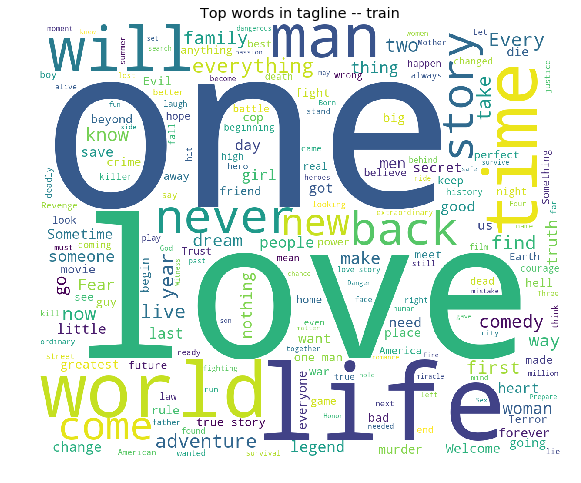

In [71]:
# Word cloud for train
plt.figure(figsize=(16, 8))
text = ' '.join(train['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tagline -- train')
plt.axis("off")
plt.show()

### *title*

<Figure size 1152x576 with 0 Axes>

Text(0.5,1,'Top words in title -- train')

(-0.5, 1199.5, 999.5, -0.5)

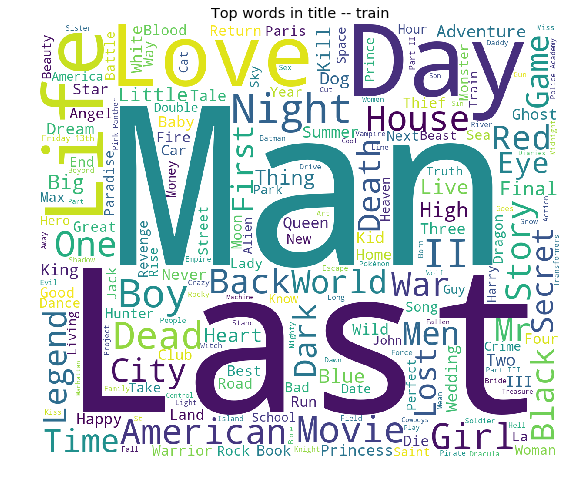

In [72]:
# Word cloud for train
plt.figure(figsize=(16, 8))
text = ' '.join(train['title'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in title -- train')
plt.axis("off")
plt.show()

### *Keywords*

In [73]:
# Create a new column to store all keywords
train['word']=train["Keywords"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['word']=test["Keywords"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Look at this column
train['word'].head()

0    [time travel, sequel, hot tub, duringcreditsst...
1        [coronation, duty, marriage, falling in love]
2    [jazz, obsession, conservatory, music teacher,...
3    [mystery, bollywood, police corruption, crime,...
4                                                  NaN
Name: word, dtype: object

In [74]:
# Create a column with the number of keywords in a movie
# This variable may reflect the diversity of this movie
train["word_div"]=train["Keywords"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test["word_div"]=test["Keywords"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

# Look at this column
train["word_div"].value_counts()

5      293
0      276
4      248
3      228
6      227
2      207
7      192
1      187
8      161
9      134
11     132
10     125
12     100
13      85
14      59
15      59
16      58
17      45
18      29
20      24
21      23
19      22
22      17
23      15
24      12
27      12
25       6
26       5
32       2
28       2
30       2
31       2
29       2
37       2
43       1
40       1
38       1
33       1
97       1
39       1
149      1
Name: word_div, dtype: int64

<Figure size 864x576 with 0 Axes>

Text(0.5,1,'Top Keywords')

(-0.5, 1199.5, 999.5, -0.5)

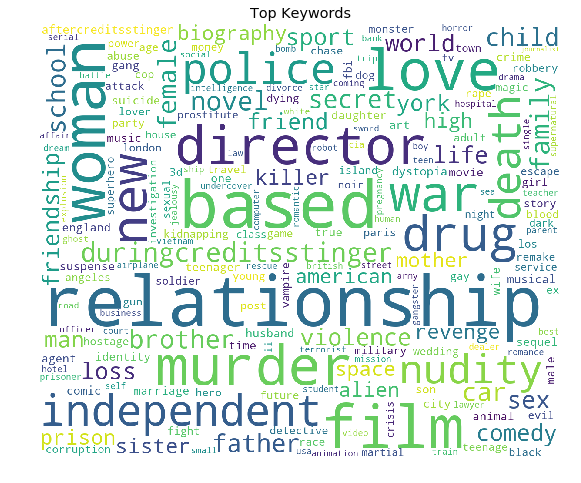

In [75]:
# Create a keywords list
words_list=list(train['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

# Create a word cloud for the keywords list
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in words_list for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top Keywords')
plt.axis("off")
plt.show()

### *crew*

In [76]:
# Look at this column
for crew in train.crew[:2]:
    print(crew)

[{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 1451

In [77]:
# Create a new column to store all crews
train['Crew']=train["crew"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['Crew']=test["crew"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Create a new column to store the number of crews
train["n_crew"]=train["crew"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test["n_crew"]=test["crew"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [78]:
# Look at the new columns
train['Crew'].head()
train['n_crew'].head()

# Count the freq
train['n_crew'].value_counts()[:10]

0    [Kelly Cantley, Steve Pink, Josh Heald, Josh H...
1    [Garry Marshall, Charles Minsky, John Debney, ...
2    [Terri Taylor, Richard Henderson, Jeffrey Stot...
3              [Sujoy Ghosh, Sujoy Ghosh, Sujoy Ghosh]
4                     [Jong-seok Yoon, Jong-seok Yoon]
Name: Crew, dtype: object

0    72
1     9
2    64
3     3
4     2
Name: n_crew, dtype: int64

2     179
11    127
10    126
3     126
12    110
9     109
8     109
14    104
4     101
7      94
Name: n_crew, dtype: int64

We can see that most movies have 2-14 crews.

In [79]:
# Create a crew list
initial_list=list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['initial_crew']=train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
test['initial_crew']=test['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
crew_list=Counter([i for j in initial_list for i in j]).most_common()

# Create top 1% crew list
n=len(crew_list)*0.01
# Select top 400 crew
common_crew=crew_list[:400]
common_crew[:20]

# Convert to a list
top_crew=[i[0] for i in common_crew]

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30),
 ('Jane Jenkins', 29),
 ('John Debney', 28),
 ('Hans Zimmer', 28),
 ('John Papsidera', 28),
 ('Francis Ford Coppola', 28)]

In [80]:
# Create a column to contain the number of top crew 
def count_var_1(row, top_list):
    count=0
    for ele in row["initial_crew"]:
        if ele in top_list:
            count+=1      
    return(count)

# Create a column to contain the ratio between the number of top crew and the total number of crew
def ratio_var_1(row, top_list):
    if row["n_crew"]==0:
        ratio=np.nan
    else:
        ratio=count_var_1(row, top_list)/(row["n_crew"])
    return(ratio)
    
# New columns
train['crew_top']=train.apply(lambda row: count_var_1(row, top_crew), axis=1)
test['crew_top']=test.apply(lambda row: count_var_1(row, top_crew), axis=1)
train['crew_top'].value_counts()

train['crew_top_ratio']=train.apply(lambda row: ratio_var_1(row, top_crew), axis=1)
test['crew_top_ratio']=test.apply(lambda row: ratio_var_1(row, top_crew), axis=1)
train['crew_top_ratio'].head()

0     1309
1      432
2      330
3      268
4      185
5      145
6       95
7       70
8       48
9       38
10      21
11      19
12      16
13       9
15       5
14       5
16       3
19       1
18       1
Name: crew_top, dtype: int64

0    0.013889
1    0.222222
2    0.046875
3    0.000000
4    0.000000
Name: crew_top_ratio, dtype: float64

### *cast*

In [81]:
# Look at this column
for cast in train.cast[:2]:
    print(cast)

[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'character'

In [82]:
# Create a new column to store all casts
train['Cast']=train["cast"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)
test['Cast']=test["cast"].apply(lambda x: [i['name'] for i in x] if x!={} else np.nan)

# Create a new column to store the number of casts
train["n_cast"]=train["cast"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)
test["n_cast"]=test["cast"].apply(lambda x: len([i['name'] for i in x]) if x!={} else 0)

In [83]:
# Look at the new columns
train['Cast'].head()
train['n_cast'].head()

# Count the freq
train['n_cast'].value_counts()[:10]

0    [Rob Corddry, Craig Robinson, Clark Duke, Adam...
1    [Anne Hathaway, Julie Andrews, H√©ctor Elizond...
2    [Miles Teller, J.K. Simmons, Melissa Benoist, ...
3    [Vidya Balan, Nawazuddin Siddiqui, Parambrata ...
4    [Kim Kang-woo, Jo Jae-hyeon, Park Si-yeon, Kim...
Name: Cast, dtype: object

0    24
1    20
2    51
3     7
4     4
Name: n_cast, dtype: int64

15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: n_cast, dtype: int64

Most movies have 9-20 casts

In [84]:
# Create a cast list
cast_list=list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
train['initial_cast']=train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
test['initial_cast']=test['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
cast_list=Counter([i for j in cast_list for i in j]).most_common()

# Create top 1% cast list
l=len(cast_list)*0.01
# Select top 400 cast
common_cast=cast_list[:400]
common_cast[:20]

# Convert to a list
top_cast=[i[0] for i in common_cast]

[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21),
 ('Jason Statham', 21),
 ('Keith David', 21),
 ('John Goodman', 21),
 ('Mel Gibson', 21),
 ('Sigourney Weaver', 21)]

In [85]:
# Create a column to contain the number of top cast
def count_var_2(row, top_list):
    count=0
    for ele in row["initial_cast"]:
        if ele in top_list:
            count+=1      
    return(count)

# Create a column to contain the ratio between the number of top cast and the total number of cast
def ratio_var_2(row, top_list):
    if row["n_cast"]==0:
        ratio=np.nan
    else:
        ratio=count_var_2(row, top_list)/(row["n_cast"])
    return(ratio)
    
# New columns
train['cast_top']=train.apply(lambda row: count_var_2(row, top_cast), axis=1)
test['cast_top']=test.apply(lambda row: count_var_2(row, top_cast), axis=1)
train['cast_top'].value_counts()

train['cast_top_ratio']=train.apply(lambda row: ratio_var_2(row, top_cast), axis=1)
test['cast_top_ratio']=test.apply(lambda row: ratio_var_2(row, top_cast), axis=1)
train['cast_top_ratio'].head()

0     1084
1      574
2      480
3      331
4      219
5      142
6       85
7       53
8       14
9        8
10       6
11       2
15       1
13       1
Name: cast_top, dtype: int64

0    0.125000
1    0.200000
2    0.019608
3    0.000000
4    0.000000
Name: cast_top_ratio, dtype: float64

In [86]:
# Write out to a csv to store the new dataset 
train.to_csv("new_train.csv", index=False)
test.to_csv("new_test.csv", index=False)